# Question Answering 



In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
!pip install farm-haystack==0.9.0

## QA for Customer Reviews

About dataset: 

In [3]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [4]:
# We will focus on Electronics
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# Let's look at one example from training set 
print(subjqa['train']['answers'][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [6]:
# Flatten the nested columns in the answer
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")


Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [7]:
# examples from the columns 
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


From the sample we can say, there are "unanswerable" questions. 

In [8]:
# Slicing the answer span from context 
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

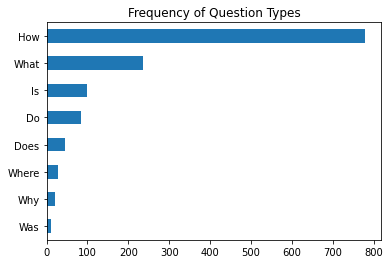

In [9]:
# types of question in the train set 
import matplotlib.pyplot as plt 
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [10]:
# examples from the most common questions 
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## Span Classification 

The common approach to formulate the extractive QA as span classification in which the model predict the start and the end positions of the answer in the context. When the question and the context are given, the model predicts start and end logits for each token. 

### Tokenization for QA 

The output of the tokenizer is a dict containing: 
* `input_ids:` the encoded tokens 
* `attention_mask:` 0/1 mask defining where to apply the attention  
* `token_type_ids:` 0/1 mask defining the context (1) and the question (0) tokens. 




In [11]:
# Using MiniLM for QA model 
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [12]:
# example for tokenization 
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [13]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [14]:
# decoding the input ids will give the concatenated question-context tokens 
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [15]:
# Load the model for QA 
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [16]:
# The outputs of the models logits 
# We need to transform them into start and end points 
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [17]:
# Applying argmax over the logits to obtain start/end positions 
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In Transformers library, we can use a pipeline that wraps these steps. 

In [18]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/question_answering.py:325: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651616334915161, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082962095737457,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253521054983139,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [19]:
# When there is no answer? 
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

### Long Passages 

The standard approach to deal with long passages is to use sliding window approach. This approach creates multiple question-context pairs for long documents. 

In [20]:
# To enable it use return_overflowing_tokens=True 
# The window size is max_seq_length 
# The stride size is doc_stride 
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [22]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



## Building QA Pipeline 

QA model in this chapter consists of two components: 
1. Retriever: is responsible for retrieving the relevant documents for a given quesry. Sparse retrievers use word frequencies. Dense retrievers use encoder like transformers to represent the document and query embeddings. 
2. Reader: is responsible for extracting the answer from the relevant documents. 

This section uses [HayStack](https://haystack.deepset.ai/overview/quick-start) QA Pipeline which has two components: Document store and Pipeline. 

**Initializing a document store** 

For document store, we will use `ElasticsearchDocumentStore` which is a search engine capable of handling various types of large documents. 

In [35]:
# First download the engine 
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [36]:
# Start the server 
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [25]:
!curl -X GET "localhost:9200/?pretty"

curl: (7) Failed to connect to localhost port 9200: Connection refused


In [37]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)


In [49]:
# Loading the documnents 
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
         for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs)

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


**Initializing a retriever**

For retriever, we will use BM25 (Best Match 25), an improved Term Frequency-Inverse Document Frequency algorithm. 



In [ ]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

**Putting all together to form a pipeline**


In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")


## Improving QA model 

1. Evaluating Retriever: Using Recall 

2. Evaluationg Reader: Using exact match and F1 Score

The rest of the section mostly related to Haystack and I am skipping them for now. 